# Data Analysis

In this file, we proceed to develop and test the pipeline that handles our dataset.

Thsi specific file is dedicated to the understanding of the "cancer" dataset provided by the National Cancer Institute, CDG Data Portal.

DATASET was provided by :
https://portal.gdc.cancer.gov/

filter applied were :

- Data Type : Gene Expression Quantification
- Experimental Strategy : RNA-seq
- Access : Open
- Project : CPTAC-3

### All the imports for all the things

In [2]:
import os
import sys
import pandas as pd
import datetime


import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  






import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

# for translation of gene symbols
import mygene

import pathlib
import scipy

from sklearn.preprocessing import normalize, MinMaxScaler

# to import libs 
sys.path.append('../src/utils')
import feature_selection, visualisation
sys.path.append('../src')
import data_handler



# datasets

# default path of the folder containing the salmon files
absolute_path = '/Users/aygalic/Thesis/data/cancer'  
metadata_path = '/Users/aygalic/Thesis/METADATA_200123.xlsx'  

pd.options.display.width = 1000

mg = mygene.MyGeneInfo()

### Some testing about gene name retrieval

In [48]:
entries = os.listdir(absolute_path)
print(entries[0])
print("______")

files = [[absolute_path+"/"+entry+"/"+file for file in os.listdir(absolute_path+"/"+entry)] for entry in entries if os.path.isdir(absolute_path+"/"+entry)]
print(files[0])
print("______")


files_of_interest = [[e for e in entries if ".tsv" in e ][0] for entries in files ]
print(files_of_interest[0])

files_of_interest = [e for e in files_of_interest if "augmented_star_gene_counts" in e ]
print(files_of_interest[0])




756a1731-8c8d-4d96-8e22-3f382275a48b
______
['/Users/aygalic/Thesis/data/cancer/756a1731-8c8d-4d96-8e22-3f382275a48b/logs', '/Users/aygalic/Thesis/data/cancer/756a1731-8c8d-4d96-8e22-3f382275a48b/17131c68-cbbb-453a-86c2-6688955807e3.rna_seq.augmented_star_gene_counts.tsv']
______
/Users/aygalic/Thesis/data/cancer/756a1731-8c8d-4d96-8e22-3f382275a48b/17131c68-cbbb-453a-86c2-6688955807e3.rna_seq.augmented_star_gene_counts.tsv
/Users/aygalic/Thesis/data/cancer/756a1731-8c8d-4d96-8e22-3f382275a48b/17131c68-cbbb-453a-86c2-6688955807e3.rna_seq.augmented_star_gene_counts.tsv


In [5]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

print(os.path.exists(files_of_interest[0]))
names = data_handler.get_names(files_of_interest[0], header = 5)
names[0:5]

True


0    ENSG00000000003.15
1     ENSG00000000005.6
2    ENSG00000000419.13
3    ENSG00000000457.14
4    ENSG00000000460.17
Name: N_ambiguous, dtype: object

In [ ]:
#symbols = mg.querymany(names, fields = ['genomic_pos', 'symbol'], scopes='ensembl.gene', species='human', verbose = False, as_dataframe = True)
#symbols

#symbols = symbols.reset_index()
#symbols = symbols.drop_duplicates(subset = ["query"])

# WE HAVE NO SYMBOLS THAT START WITH ENSG

#[s for s in symbols["symbol"].fillna("") if s.startswith('ENSG') ]

In [7]:
#sorted_sym = symbols.sort_values(['genomic_pos.chr', 'genomic_pos.start'], ascending=[True, True])

#sorted_values = sorted_sym[['genomic_pos.chr', 'genomic_pos.start']].values
#sorted_values

### Just a bit of testing 

loading samples...
loaded 2259 / 2259 samples
selecting genes based on median absolute deviation threshold:  2 ...
0.0
285733.0


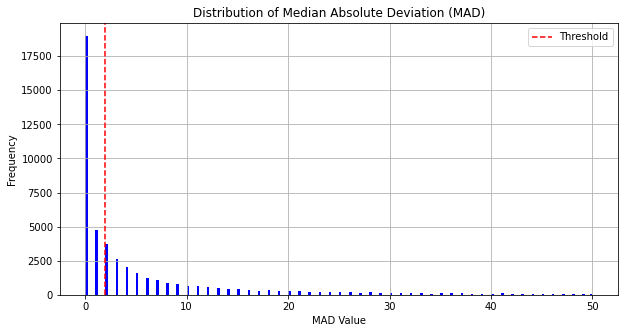

removing 39580 genes under the MAD threshold from the dataset
number of genes selected :  21080
number of genes selected :  21080
log(1 + x) transformation...
scaling to [0, 1]...
shape of the dataset : (2259, 21080)
number of seq in the dataset : 2259


In [49]:
importlib.reload(feature_selection) # to allow modification of the script without restarting the whole session
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session


as_time_series = True
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_cancer(
    path = absolute_path,
    feature_selection_threshold = 2, 
    batch_size = 32, 
    normalization = False,
    MT_removal = False)

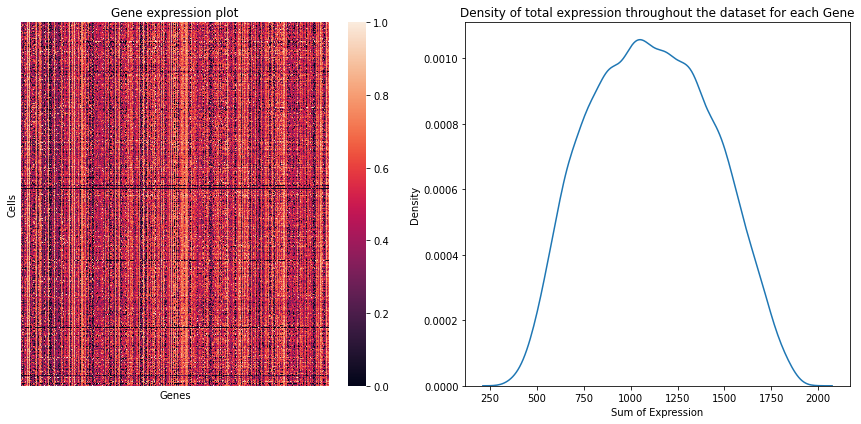

In [50]:
data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
data = pd.DataFrame(data)
data.columns = gene_names
data.index = index_names
visualisation.dataset_plot(data)


In [91]:
print(gene_names)

1         ENSG00000000005.6
10       ENSG00000001460.18
17       ENSG00000001630.17
18       ENSG00000001631.16
20       ENSG00000002079.14
                ...        
60652     ENSG00000288663.1
60654     ENSG00000288667.1
60656     ENSG00000288670.1
60658     ENSG00000288674.1
60659     ENSG00000288675.1
Name: N_ambiguous, Length: 21080, dtype: object



get the dataset as a numpy object for data manipulation

In [92]:
# get everything out of TensorFlow back to numpy/pandas
data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)

data = pd.DataFrame(data)
data.columns = gene_names
data.index = index_names


In [95]:
data

N_ambiguous,ENSG00000000005.6,ENSG00000001460.18,ENSG00000001630.17,ENSG00000001631.16,ENSG00000002079.14,ENSG00000002330.14,ENSG00000002745.13,ENSG00000002746.15,ENSG00000002822.15,ENSG00000003137.8,...,ENSG00000288612.1,ENSG00000288632.1,ENSG00000288637.1,ENSG00000288658.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
/Users/aygalic/Thesis/data/cancer/756a1731-8c8d-4d96-8e22-3f382275a48b/17131c68-cbbb-453a-86c2-6688955807e3.rna_seq.augmented_star_gene_counts.tsv,0.264178,0.774753,0.715565,0.840109,0.536976,0.816275,0.469874,0.572886,0.637795,0.594370,...,0.564676,0.515643,0.472484,0.181526,0.747775,0.666948,0.821863,0.838511,0.560693,0.459940
/Users/aygalic/Thesis/data/cancer/34aaddf2-f2ac-4a67-9a8c-a56c8fe78037/48c47bf1-90db-4783-ad31-42eb9ef1c10f.rna_seq.augmented_star_gene_counts.tsv,0.253678,0.626850,0.601584,0.705787,0.491499,0.706561,0.432534,0.523594,0.482018,0.475082,...,0.421592,0.380210,0.159319,0.181526,0.584295,0.512145,0.631103,0.640210,0.162077,0.360175
/Users/aygalic/Thesis/data/cancer/12b3d9cf-18af-4930-8d5e-2093f0f82df1/67624292-fd1c-4e48-bd04-aaba940d2c84.rna_seq.augmented_star_gene_counts.tsv,0.324391,0.722686,0.712339,0.894308,0.443381,0.889253,0.300749,0.430662,0.613543,0.454152,...,0.639354,0.485524,0.402076,0.181526,0.611301,0.512145,0.701123,0.765499,0.418962,0.406692
/Users/aygalic/Thesis/data/cancer/4fb72adf-dc84-4945-850a-2d2e585bdf24/156adfcd-b9fe-466d-8476-1c8c11656de0.rna_seq.augmented_star_gene_counts.tsv,0.214383,0.836277,0.768127,0.826228,0.447480,0.851155,0.390713,0.593480,0.546285,0.320025,...,0.560921,0.541734,0.454704,0.296056,0.611301,0.539824,0.818184,0.712634,0.722769,0.297896
/Users/aygalic/Thesis/data/cancer/e9be8247-b6e1-486a-afcd-e33e71684229/7024e80d-ec80-4399-ae2a-8a8493f54ed1.rna_seq.augmented_star_gene_counts.tsv,0.177313,0.689852,0.789938,0.822646,0.555722,0.804307,0.426520,0.369704,0.606969,0.520695,...,0.585443,0.529123,0.472484,0.265931,0.474078,0.607004,0.680342,0.689450,0.648306,0.610038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/Users/aygalic/Thesis/data/cancer/403d50f3-c750-4fda-9544-b20b10064d9b/04d33a43-a092-495f-9ef1-84f4dc9da674.rna_seq.augmented_star_gene_counts.tsv,0.350129,0.735297,0.723793,0.807843,0.373192,0.793206,0.362436,0.415286,0.640420,0.589166,...,0.526990,0.350090,0.392717,0.436057,0.685704,0.539824,0.777213,0.712634,0.662482,0.426193
/Users/aygalic/Thesis/data/cancer/dbbadbf7-efe3-4490-ad98-5258a0b81907/712d7c9f-f3d5-457b-9c8f-9ade469f5c3f.rna_seq.augmented_star_gene_counts.tsv,0.330042,0.677142,0.693642,0.801910,0.469669,0.781191,0.487644,0.595105,0.518139,0.392097,...,0.501156,0.501163,0.259838,0.229060,0.666931,0.487855,0.747995,0.720231,0.455006,0.501242
/Users/aygalic/Thesis/data/cancer/0d46a5a4-5f09-4373-a3f2-a8a4b6b69c25/bd4ca7de-b046-451a-8a07-722f9b913222.rna_seq.augmented_star_gene_counts.tsv,0.378325,0.732680,0.678322,0.836657,0.420671,0.855402,0.300749,0.487714,0.635116,0.372244,...,0.629994,0.541734,0.419157,0.296056,0.553419,0.487855,0.786091,0.769295,0.538407,0.331643
/Users/aygalic/Thesis/data/cancer/c2e36988-bde9-462c-8d5f-9d86ac60eb6d/6dcd6cc5-d6ec-46b3-9960-a33cc31806ec.rna_seq.augmented_star_gene_counts.tsv,0.426494,0.738295,0.699779,0.817085,0.393095,0.840891,0.372638,0.897458,0.503885,0.814960,...,0.822880,0.485524,0.301557,0.296056,0.646366,0.563534,0.747995,0.909661,0.486230,0.360175


# quick viz of the dataset 

In [ ]:
params = {   # keeping only symbols that can be ordered on the dataset and sorting the whole thing
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        #"MT_removal" : True, 
        "log1p" : True,
        "min_max" : True}
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_cancer(**params)

data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
data = pd.DataFrame(data)
data.columns = gene_names
data.index = index_names
visualisation.dataset_plot(data)
